# Raport Task II 

Rybczyński Jędrzej, 12.08.2022

## Wstęp

W tym Markdownie chciałem krótko skupić się na raporcie opisującym mój dotychczasowy postęp, wnioski, dalsze plany etc. związane z taskiem II polegającym na predykcji ocen win na podstawie datasetu opisującego jego cechy.

## EDA

W ramach EDA: 
- zbadałem rodzaje cech jakie występują w datasetcie (1 tekstowa, 2 numeryczne (w tym jedna z nich wyjściowa points), pozostałe 7 kategoryczne)
<br>

- zbadałem braki w danych oraz rozpisałem wstępny plan na ich uzupełnianie: <br>
Ponad 50% braków w `region_2`, do rozważania czy całkowicie nie odrzucić tej zmiennej jako, że i tak mamy `region_1`. <br>
Wstępny pomysł na uzupełnianie braków to:
- `country`, `province` - mode
- `price` - mean
- `region_1`, `designation` - KNN / dodatkowa kategoria 'NAN'
- `region_2` - drop/KNN
<br>

- zbadałem rozkład zmiennej wyjściowej `points`
<br>

- przeszedłem do pandas-profiling, na oryginalnym datasetcie nie można wyciągnąć zbyt wiele wniosków związanych np. z korelacjami zmiennych, ponieważ zmienne kategoryczna są bardzo zróżnicowane, zastosowałem trik, który polegał na uzupełnianiu mniej popularnych wartości zmiennych kategoryczncyh (poniżej 1% wystąpień) wartością 'Other'

Wnioski z pandas-profiling:
- bardzo dużo obserwacji, ponad 150k, z czego jednak 60k to **duplikaty**, zastanawiam się czy należy je usunąć czy może jednak celowo znajdują się w datasetcie, jasnym jest, że model będzie wypadał znacznie lepiej na zbiorze zawierającym duplikaty,
- wysoka korelacja zmiennych numerycznych `price` oraz `points`,
- wysokie korelacje zmiennych związanych z lokalizacją `region_1`, `region_2`, `country` oraz `province` (ciężko też stwierdzić czy niektóre korelacje nie są nieco zaburzone przez nadpisanie wartością 'Other'), w docelowym modelu warto też być może rozważyć jedną najsilniejszą cechę związaną z lokalizacją, nie ma chyba sensu overlapować tych samych informacji
- **feature selection**, właściwie to o czym pisałem wyżej, duża część cech pokrywa się między sobą, dlatego do rozważenia wybranie podzbioru cech dla docelowego modelu,
- mamy bardzo zróżnicowane zmienne kategoryczne, dlatego klasyczny OneHotEncoding może nie być dobrym pomysłem (tym bardziej, że mamy już bardzo dużo obserwacji), warto rozważyć np. encodowanie mniej popularnych wartości jako 'Other' lub CatBoost encoding,
- niezbalansowana zmienna numeryczna `price`, warto będzie ją potraktować jakimś RobustScalerem w przypadku zastosowania modeli liniowych

## Features Engineering

Dotychczasowe kroki podjęte w ramach features engineering to:
- sprowadzenie problemu do klasyfikacji wieloklasowej, z założenia zmienna wyjściowa jest zmienną ciągłą, jednak dobrym podejściem wydaje się być binning, czyli jej zdyskretyzowanie na podgrupy, które jasno są wskazane chociażby w tym artykule https://www.wine-searcher.com/wine-scores. Warto też pewnie jednak rozważyć z osobna problem regresji.

In [ ]:
wine_scores

- próbowałem usuwać duplikaty, ale skuteczność modelu mocno na tym cierpiała, zaprezentuje porównanie wyników w dalszej części
- uzupełniłem brakujące wartości zgodnie z założeniami opisanymi wcześniej, jednak przez rozległość zbioru nie mogłem zastosować KNNa, dlatego tymczasowo uzupełniałem braki kategoryczne przez 'NAN', zdecydowałem się też odrzucić zmienną `region_2`, która zawierała 60% braków, jako że w zbiorze danych mamy wystarczająco dużo cech opisujących lokalizacje
- zastanawiam się nad dalszym encodowaniem zmiennych kategorycznych, do tej pory rozważałem modele ala sentiment analysis, które wykorzystywały tylko zmienną tekstową `description` oraz CatBoosta, który korzystał ze swojego natywnego encodowania zmiennych jakościowych. OneHotEncoding jest problematyczny przez duże zróżnicowanie zmiennych. Pomysłem jest nadpisywanie mniej popularnych wartości przez 'Other' co wykorzystałem w ramach EDA, jednak wtedy tracimy część informacji.

## Text preprocessing

W ramach obróbki zmiennej teksowej `description` podjąłem dosyć klasyczne, następujące kroki:
- lower casing
- punctuations removal
- English stopwords removal z wykorzystaniem biblioteki `nltk`
- Stemming

## Text Representation

Do reprezentacji zmiennej tekstowej `description` wybrałem następujące metody:
- Bag Of Words
- TF-IDF
- Bigram

## Modeling

1) Naive Bayes (Baseline Model) - jako baseline wybrałem Naive Bayes tylko na zminnej tekstowej `description`, który jak na baseline dał zadowalające wyniki, zwłaszcza z wykorzystaniem Bigramu.

In [ ]:
Image(filename='raport_images/baseline_bigram.png') 

2) Random Forest tylko na zmiennej tekstowej `description`. Klasyczny random forest, którego wyniki też były przyjemne, jednak czas trenowania modelu to ponad 5 minut. Przygotowałem też porównanie jak wypada z i bez duplikatów dla BOW oraz TF-IDF, niestety nie mogłem wytrenować RF na Bigramie, bo po transformacji na Bigram jest 575k kolumn (vs 30k BOW), więc czas trenowania był zbyt długi. Po lewo z duplikatami, po prawo bez.

In [ ]:
Image(filename='raport_images/rf_comparison.png') 

In [ ]:
3) CatBoost na wszystkich cechach. Chciałem go głównie zastosować w celu wygenerowania feature importances, jest on też o tyle wygodny, że nie muszę encodować ani cech kategorycznych ani reprezentować tekstu, obie z tych rzeczy przyjmuje jako parametr i robi sobie po swojemu. Co prawda czas trenowania był dosyć długi (ponad 20 minut na 1500 iteracjach i learning_rate 0.45). Wyniki oraz feature importance prezentują się następująco:

In [ ]:
Image(filename='raport_images/feat_importances.png') 

In [ ]:
Image(filename='raport_images/catboost.png') 

Wyniki nieco lepsze od RF, pewnie dałoby się go wytrenować jeszcze mocniej, ale zasoby obliczeniowe mi na to nie pozwalają xD Ogólnie testowałem te maszynki na Azure, ale tbh średnio to idzie, porównywalnie, a nawet szybciej idzie mi to szkolić lokalnie.

## TODO

W następnych krokach mam zamiar wytestować jeszcze kilka podejść, po pierwsze:
- wytestować RF/Logreg nie tylko ze zmienną tekstową, ale ze wszystkimi zmiennymi, tylko że jak próbowałem to robić to w momencie, kiedy próbuje łączyć zakodowane BOW/TF-IDF z pozostałymi cechami to wywala mi memory allocation erorr (tam na końcu notebooka to próbowałem) i szczerze trochę utknąłem jak to dalej pociągnąć, Azure tak samo nie dawał rady
- spoko by było jakoś tunować parametry, tylko właśnie jak to zrobić jak pojedynczy RF mi się trenuje 5 minut, jakiś prostszy GridSearch albo coś?
- reprezentacje tych zróżnicowanych cech kategorycznych, na ten moment miałem w głowie tylko to 'Other', ale pewnie są jakieś lepsze opcje
- mimo wszystko spróbować jakoś uzupełnić braki tym KNNem
- zastanowić się nad tymi duplikatami, czy chcemy ostatecznie model bez nich, czy jednak uznajemy, że nie bez powodu są w datasetcie
- może jakiś GloVe Embedding z siecia neuronowa dla samej zmiennej tekstowej `description`, tym bardziej że widać po bigramie na Naive Bayesie, że łączenie słów ma potencjał
- głębsza analiza i przetwarzanie samej zmiennej teksowej aniżeli pozostałych cech, jako że to ona ma największy wpływ na wynik
- regresja zamiast multiklasyfikacji

# Raport Task II - Przyrost #2

## `wine_reviews_deeplearning.ipynb`

W ramach dalszej pracy nad taskiem zaimplementowałem następujące funkcje:
- Stworzyłem osobny notebook `wine_reviews_deeplearning.ipynb` w ramach, którego zastosowałem podejścia typowo DeepLearningowe, word embeddingi, rekurencyjne sieci neuronowe, rzutowałem też embedding stworzony na naszym zbiorze do 2D za pomocą t-SNE, na rysunku poniżej możemy jasno zobaczyć pewne podgrupy np. owoców pogrupowane razem.

In [ ]:
Image('raport_images/2d_tsne.png', width=500)


- Word Embeddingi, które zdecydowałem się wytestować to pretrained word2vec 300d, pretrained GloVe 300d oraz Embedding wyuczony na zbiorze treningowym za pomocą trainable warstwy keras Embedding.


- Co do samych sieci neuronowych, testowałem różne architektury, mniej i bardziej skomplikowane z Dropoutami, Bidirectionale LSTM itp., ale ostatecznie wybrałem sieć z dwoma zasadniczymi warstwami widoczną na poniższym rysunku: LSTM(100, dropout=0.2) oraz GlobalMaxPooling1D.

In [ ]:
Image('raport_images/lstm_model.png', width=500)

- Najlepiej spośród Embeddingów word2vec / GloVe / keras trainable wypadł GloVe, wyniki poniżej:

In [ ]:
Image('raport_images/lstm_results.png', width=400)

Komentując krótko wyniki sieci, wydaje mi się, że całkiem przyzwoite, accuracy na poziomie 0.75, trochę lepiej radzi sobie z rozróżnianiem 4 kategorii niż las losowy. Biorąc pod uwagę, że description jest tylko opisem butelki wina od producenta nie jest to najgorszy wynik. Nadal wypada jednak gorzej od CatBoosta, którego wyniki są widoczne poniżej, CatBoost używa jednak wszystkich cech, nie tylko zmiennej tekstowej.

In [ ]:
Image('raport_images/catboost_results.png', width=400)

- **Stacking**, zdecydowałem się na stacking modelu CatBoosta i LSTM w dosyć prymitywny sposób, łącząc predykcje prawdopodobienśtw z mnożnikiem 0.7 dla CatBoosta oraz 0.3 dla LSTMa. Udało mi się dzięki temu ulepszyć wyniki do `accuracy` na poziomie 0.8 oraz solidnych średnich `precision` / `recall` / `f1`.

In [ ]:
Image('raport_images/stacking_results.png', width=400)

## `wine_reviews.ipynb`

Wracając do notebooka z klasycznymi podejściami to tam dodałem kolejno:
- korzystałem z FAMD (https://towardsdatascience.com/5-must-know-dimensionality-reduction-techniques-via-prince-e6ffb27e55d1) do rzutowania wszystkich cech do 2 wymiarów i plotowania tego na wykresie w celu poszukiwania jakiś wzorców, generalnie tendencja była taka, że prezentowało się to dosyć skośnie, mniej więcej tak:

In [ ]:
Image('raport_images/famd.png', width=375)

- Feature selection korzystając ze scikit-learnowskiego Mutual Information zastosowane na DataFramie z zakodowanymi kategoriami Other, co ciekawe wskazał on, że tylko `price` ma istotny wpływ na zmienną wyjściową

In [ ]:
Image('raport_images/MI.png', width=175)

- Cutoff dla TF-IDFa, o którym rozmawialiśmy, generalnie testowałem tu kilka podejść, po pierwsze znalazłem, że w parametrach, które przyjmuje `TfidfVectorizer()` za kontrolę 'wielkości' słownika odpowiadają parametry `min_df`, `max_df` oraz `max_features`. Trochę z nimi ekesperymentowałem, ponadto próbowałem też odcinać wartości korzystając z argumentu `idf_`, czyli wartości IDF na zafitowanym zbiorze. Koniec końców zdecydowałem się na ustawienie `max_features=1000`, dawał on najbardziej przyzwoite wyniki dla późniejszych modeli oraz mocno redukował wektor cech do 1000 z ponad 20k.

- Po cutoffie TF-IDFa mogłem połączyć zmienną tekstową z pozostałymi zmiennymi, testowałem w ten sposób między innymi Random Forest i SGD, ale wyniki nadal były takie sobie, zwłaszcza modele nie radzą sobie z predykcją 4 klasy. Próbowałem też wykluczyć pozostałe zmienne kategoryczne i uwzględniać tylko dodatkowo `price` zgodnie z tym co wskazał MI, ale wyniki nadal były średnie.

In [ ]:
Image('raport_images/rf_all.png', width=400)

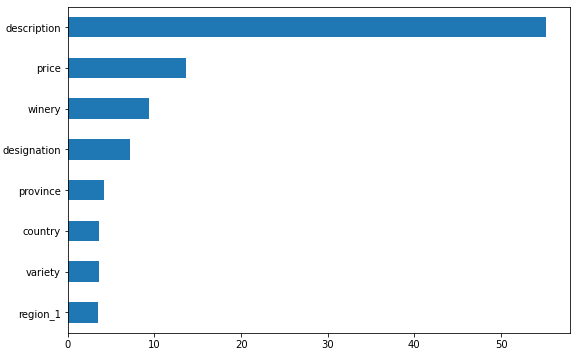

In [4]:
Image(filename='raport_images/feat_importances.png') 

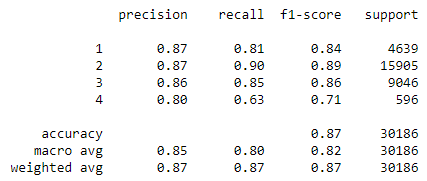

In [5]:
Image(filename='raport_images/catboost.png') 

Wyniki nieco lepsze od RF, pewnie dałoby się go wytrenować jeszcze mocniej, ale zasoby obliczeniowe mi na to nie pozwalają xD Ogólnie testowałem te maszynki na Azure, ale tbh średnio to idzie, porównywalnie, a nawet szybciej idzie mi to szkolić lokalnie.

## TODO

W następnych krokach mam zamiar wytestować jeszcze kilka podejść, po pierwsze:
- wytestować RF/Logreg nie tylko ze zmienną tekstową, ale ze wszystkimi zmiennymi, tylko że jak próbowałem to robić to w momencie, kiedy próbuje łączyć zakodowane BOW/TF-IDF z pozostałymi cechami to wywala mi memory allocation erorr (tam na końcu notebooka to próbowałem) i szczerze trochę utknąłem jak to dalej pociągnąć, Azure tak samo nie dawał rady
- spoko by było jakoś tunować parametry, tylko właśnie jak to zrobić jak pojedynczy RF mi się trenuje 5 minut, jakiś prostszy GridSearch albo coś?
- reprezentacje tych zróżnicowanych cech kategorycznych, na ten moment miałem w głowie tylko to 'Other', ale pewnie są jakieś lepsze opcje
- mimo wszystko spróbować jakoś uzupełnić braki tym KNNem
- zastanowić się nad tymi duplikatami, czy chcemy ostatecznie model bez nich, czy jednak uznajemy, że nie bez powodu są w datasetcie
- może jakiś GloVe Embedding z siecia neuronowa dla samej zmiennej tekstowej `description`, tym bardziej że widać po bigramie na Naive Bayesie, że łączenie słów ma potencjał
- głębsza analiza i przetwarzanie samej zmiennej teksowej aniżeli pozostałych cech, jako że to ona ma największy wpływ na wynik
- regresja zamiast multiklasyfikacji

# Raport Task II - Przyrost #2

## `wine_reviews_deeplearning.ipynb`

W ramach dalszej pracy nad taskiem zaimplementowałem następujące funkcje:
- Stworzyłem osobny notebook `wine_reviews_deeplearning.ipynb` w ramach, którego zastosowałem podejścia typowo DeepLearningowe, word embeddingi, rekurencyjne sieci neuronowe, rzutowałem też embedding stworzony na naszym zbiorze do 2D za pomocą t-SNE, na rysunku poniżej możemy jasno zobaczyć pewne podgrupy np. owoców pogrupowane razem.

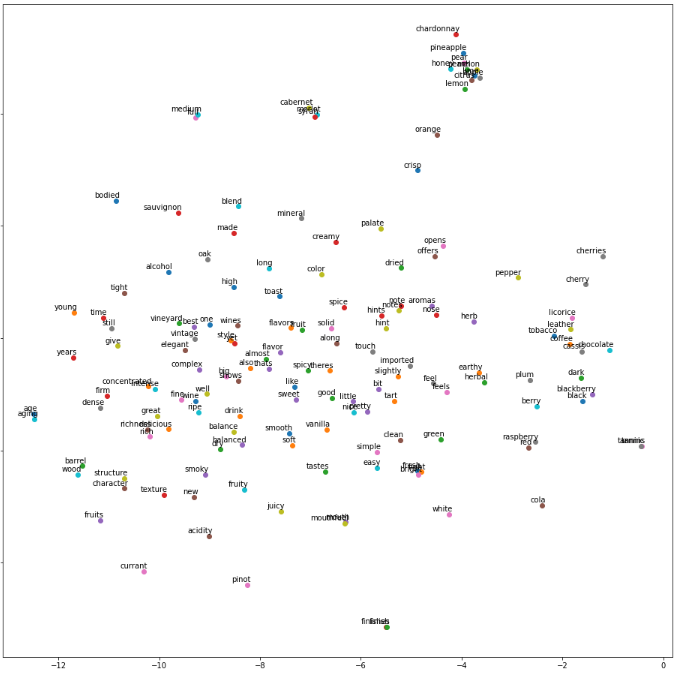

In [14]:
Image('raport_images/2d_tsne.png', width=500)


- Word Embeddingi, które zdecydowałem się wytestować to pretrained word2vec 300d, pretrained GloVe 300d oraz Embedding wyuczony na zbiorze treningowym za pomocą trainable warstwy keras Embedding.


- Co do samych sieci neuronowych, testowałem różne architektury, mniej i bardziej skomplikowane z Dropoutami, Bidirectionale LSTM itp., ale ostatecznie wybrałem sieć z dwoma zasadniczymi warstwami widoczną na poniższym rysunku: LSTM(100, dropout=0.2) oraz GlobalMaxPooling1D.

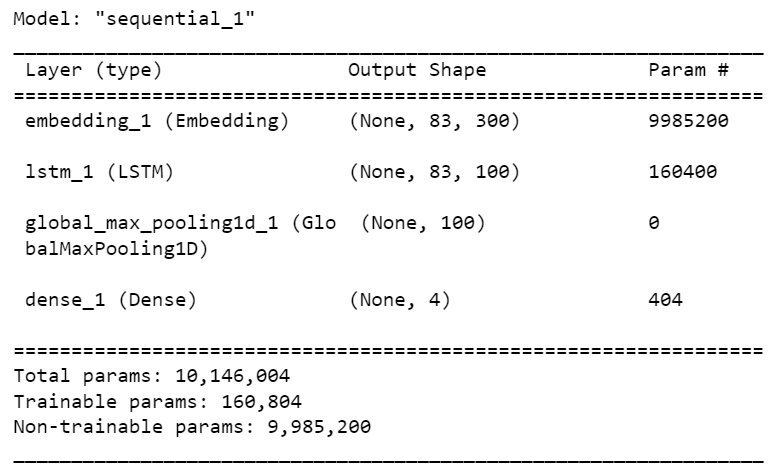

In [7]:
Image('raport_images/lstm_model.png', width=500)

- Najlepiej spośród Embeddingów word2vec / GloVe / keras trainable wypadł GloVe, wyniki poniżej:

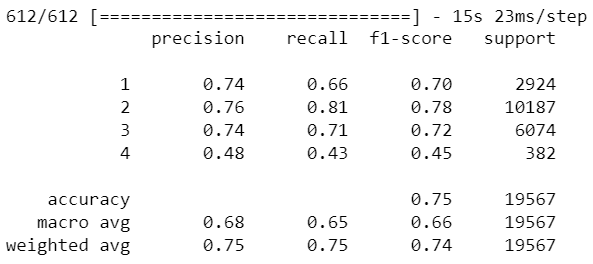

In [29]:
Image('raport_images/lstm_results.png', width=400)

Komentując krótko wyniki sieci, wydaje mi się, że całkiem przyzwoite, accuracy na poziomie 0.75, trochę lepiej radzi sobie z rozróżnianiem 4 kategorii niż las losowy. Biorąc pod uwagę, że description jest tylko opisem butelki wina od producenta nie jest to najgorszy wynik. Nadal wypada jednak gorzej od CatBoosta, którego wyniki są widoczne poniżej, CatBoost używa jednak wszystkich cech, nie tylko zmiennej tekstowej.

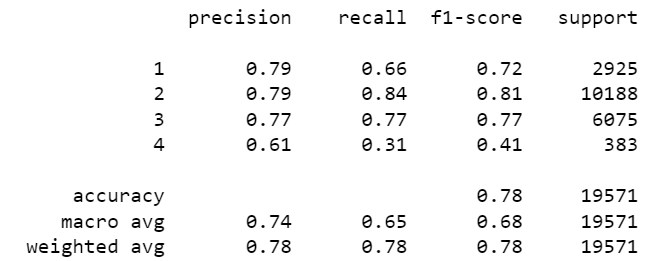

In [30]:
Image('raport_images/catboost_results.png', width=400)

- **Stacking**, zdecydowałem się na stacking modelu CatBoosta i LSTM w dosyć prymitywny sposób, łącząc predykcje prawdopodobienśtw z mnożnikiem 0.7 dla CatBoosta oraz 0.3 dla LSTMa. Udało mi się dzięki temu ulepszyć wyniki do `accuracy` na poziomie 0.8 oraz solidnych średnich `precision` / `recall` / `f1`.

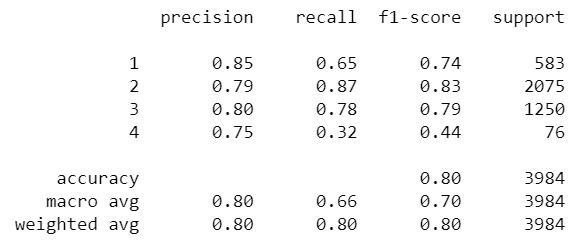

In [33]:
Image('raport_images/stacking_results.png', width=400)

## `wine_reviews.ipynb`

Wracając do notebooka z klasycznymi podejściami to tam dodałem kolejno:
- korzystałem z FAMD (https://towardsdatascience.com/5-must-know-dimensionality-reduction-techniques-via-prince-e6ffb27e55d1) do rzutowania wszystkich cech do 2 wymiarów i plotowania tego na wykresie w celu poszukiwania jakiś wzorców, generalnie tendencja była taka, że prezentowało się to dosyć skośnie, mniej więcej tak:

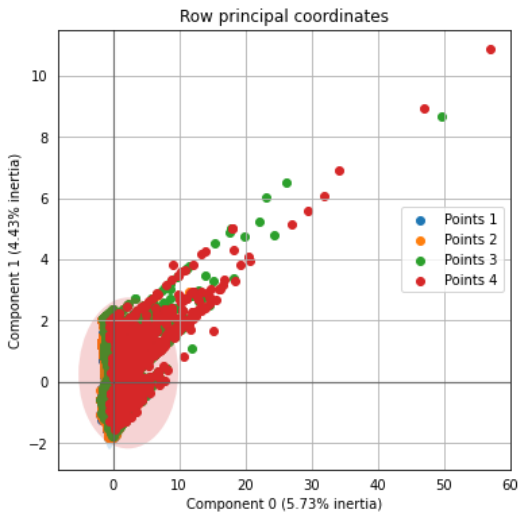

In [21]:
Image('raport_images/famd.png', width=375)

- Feature selection korzystając ze scikit-learnowskiego Mutual Information zastosowane na DataFramie z zakodowanymi kategoriami Other, co ciekawe wskazał on, że tylko `price` ma istotny wpływ na zmienną wyjściową

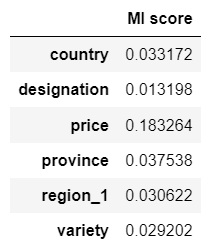

In [28]:
Image('raport_images/MI.png', width=175)

- Cutoff dla TF-IDFa, o którym rozmawialiśmy, generalnie testowałem tu kilka podejść, po pierwsze znalazłem, że w parametrach, które przyjmuje `TfidfVectorizer()` za kontrolę 'wielkości' słownika odpowiadają parametry `min_df`, `max_df` oraz `max_features`. Trochę z nimi ekesperymentowałem, ponadto próbowałem też odcinać wartości korzystając z argumentu `idf_`, czyli wartości IDF na zafitowanym zbiorze. Koniec końców zdecydowałem się na ustawienie `max_features=1000`, dawał on najbardziej przyzwoite wyniki dla późniejszych modeli oraz mocno redukował wektor cech do 1000 z ponad 20k.

- Po cutoffie TF-IDFa mogłem połączyć zmienną tekstową z pozostałymi zmiennymi, testowałem w ten sposób między innymi Random Forest i SGD, ale wyniki nadal były takie sobie, zwłaszcza modele nie radzą sobie z predykcją 4 klasy. Próbowałem też wykluczyć pozostałe zmienne kategoryczne i uwzględniać tylko dodatkowo `price` zgodnie z tym co wskazał MI, ale wyniki nadal były średnie.

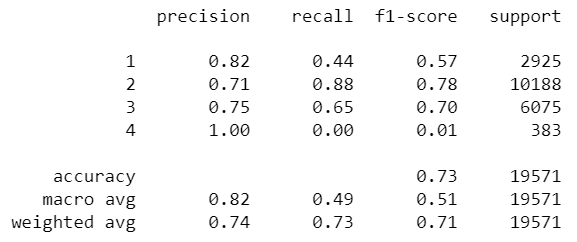

In [35]:
Image('raport_images/rf_all.png', width=400)